# Import modules

In [1]:
# -*- coding: utf-8 -*-
import numpy
import random
from matplotlib import pyplot as plt
from math import exp
%matplotlib inline

# Initial parameters

In [2]:
# Population size
n = 10

# Default Time beginning
t=0

# Default trial duration
duration = 1.00 #second

# Default Time resolution
dt = 0.0001 #second 0.0001
 
# Thresholds (from paper) x200
Cortex_h   =  20.0
Striatum_h =  0.00    #depends of dopamine level, see below
Stn_h      = -20.0
Gpi_h      =  20.0
Thalamus_h = -50.0

# Time constants 
CtxTha_tau = 0.005 #second
StnCtx_tau = 0.020 #second "5ms for all of the synapses except synapses from cortex to STN for which it's 20ms"
StrCtx_tau = 0.005 #second
GpiStr_tau = 0.005 #second
GpiStn_tau = 0.005 #second
ThaGpi_tau = 0.005 #second

# Weights
CtxTha_G = 1.25
StnCtx_G = 2
StrCtx_G = 0.5 #depends of dopamine level, see below
GpiStr_G = 16
GpiStn_G = 12.5
ThaGpi_G = 0.2

# inputs
Cortex_I   = 0
Striatum_I = 0
Stn_I      = 0
Gpi_I      = 0
Gpi_Ie     = 0
Gpi_Ii     = 0
Thalamus_I = 0

# Activities at time t:
CtxTha_m = 0
StnCtx_m = 0
StrCtx_m = 0
GpiStr_m = 0
GpiStn_m = 0
ThaGpi_m = 0

# Activities at dt
CtxTha_dm  = 0
StrCtx_dm  = 0
StnCtx_dm  = 0
GpiStr_dm  = 0
GpiStn_dm  = 0
ThaGpi_dm  = 0

# Delays:
CtxTha_D = 0.005
StnCtx_D = 0.005
StrCtx_D = 0.006
GpiStr_D = 0.01
GpiStn_D = 0.005
ThaGpi_D = 0.005

# Initialization of the random generator (reproductibility !)
numpy.random.seed(1)


# Dopamine dependency : Weight & Threshold

In [3]:
# relative level of Striatal Dopamine Vs Normal (%)

def Striatum_Dh(D):                                                  #function calculating the Striatum 
    Striatum_h = -0.02 + 0.03 * (1-(1.1/(1+0.1*exp(-0.03*(D-100))))) #Treshold depending on the relative 
    return Striatum_h                                                #Dopamine level D (%)

def StrCtx_DG(D):                          #function calculating the Cortex_Striatum Weight 
    StrCtx_G = 0.75/(1+exp(-0.09*(D-60)))  #depending on the relative Dopamine level D (%)
    return StrCtx_G

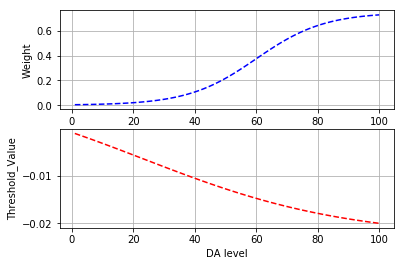

In [4]:
#Plotting the results to check the value

x=0
DA_Level=[]
Weight_Calculated=[]
StrTh_Calculated=[]

while x < 100:
    x=x+1
    DA_Level.append(x)

    f=StrCtx_DG(x)
    Weight_Calculated.append(f)
    
    h=Striatum_Dh(x)
    StrTh_Calculated.append(h)
    
plt.figure(1)
plt.subplot(211)
plt.plot(DA_Level,Weight_Calculated,'b--')
plt.ylabel('Weight')
plt.xlabel('DA level')
plt.grid()

plt.subplot(212)
plt.plot(DA_Level,StrTh_Calculated, 'r--')
plt.ylabel('Threshold_Value')
plt.xlabel('DA level')
plt.grid()

plt.show()

# Noise Function

In [5]:
#Noise level (%)
Cortex_N   =   2.00   #*200
Striatum_N =   0.20
Stn_N      =   0.20
Gpi_N      =   6.00
Thalamus_N =   0.20

In [6]:
def noise(Z, level):    #Z = size of the population
    Z = (numpy.random.uniform(0,10,Z)) # or Z = (numpy.random.uniform(-level/2,level/2,Z))*Z
    return numpy.maximum(Z,0.0)

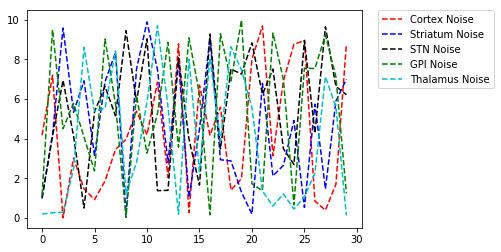

In [7]:
#EXAMPLES and plots of noise given by the formula above

n1 = noise(30,Cortex_N) 
n2 = noise(30,Striatum_N) 
n3 = noise(30,Stn_N)      
n4 = noise(30,Gpi_N)      
n5 = noise(30,Thalamus_N)
plt.plot(n1,'r--',label='Cortex Noise')
plt.plot(n2,'b--',label='Striatum Noise')
plt.plot(n3,'k--',label='STN Noise')
plt.plot(n4,'g--',label='GPI Noise')
plt.plot(n5,'c--',label='Thalamus Noise')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Basal Ganglia Population

In [8]:
# Connectivity J

CtxTha_J = 1
StrCtx_J = 1
StnCtx_J = 1
GpiStn_J = 1
GpiStr_J = 1
ThaGpi_J = 1

In [9]:
#-------------- Matrix connectivity -------------------

#Population in array with n neurons
Cortex_pop   = numpy.zeros((1,n))
Striatum_pop = numpy.zeros((1,n))
Stn_pop      = numpy.zeros((1,n))
Gpi_pop      = numpy.zeros((1,n))
Thalamus_pop = numpy.zeros((1,n))

def connectivity_matrix(n,min=1,max=10):  #n=number of neurons, min and max are the limit of the randomness
    matrix = [[random.randint(min, max) for i in range(n)] for j in range(n)]

    # Disable recurrent connexion
    for i in range(n):
        matrix[i][i] = 0

    # reciprocity : ij=ji
    for i in range(n):
        for j in range(n):
            matrix[j][i] = matrix[i][j]

    return matrix

l=connectivity_matrix(5,0,1)
l5=numpy.matrix(l)
print(l5)

[[0 0 0 0 1]
 [0 0 1 0 0]
 [0 1 0 1 1]
 [0 0 1 0 1]
 [1 0 1 1 0]]


# Neurons dynamics: Iteration and parameters update

In [10]:
it=0   #Number of iteration (with step dt) : a simple iteration counter

time_value=[0] #we put in a list every time to retrieve them in a gradual order

#we put in a list every value of activity to retrieve them in a time order; easy way to substract the delay
CtxTha_value=[0] 
StnCtx_value=[0]
StrCtx_value=[0]
GpiStr_value=[0]
GpiStn_value=[0]
ThaGpi_value=[0]

# Value of m(t-delta_t) calculated after each iteration ; for all population
R1=0    #CtxTha_m(t-CtxTha_D)=0
R2=0    #StrCtx_m(t-StrCtx_D)=0
R3=0    #StnCtx_m(t-StnCtx_D)=0
R4=0    #GpiStn_m(t-GpiStn_D)=0
R5=0    #GpiStr_m(t-GpiStr_D)=0
R6=0    #ThaGpi_m(t-ThaGpi_D)=0

In [11]:
#Function returning the corrected Input
def Ic(Input=0,threshold=0):
    
    if Input - threshold <= 0:
        return 0
    else:
        return (Input - threshold)

In [12]:
while t < duration:    # when the time is strictly under 1 seconde
    
    t = t+dt           #for each iteration, add (the step) dt to the time
    it += 1            #for each iteration, add 1 to the iteration counter
    
    CtxTha_m += CtxTha_dm    # we add the activity (dm) to the global activity (m),
    StnCtx_m += StnCtx_dm    # after a step dt ; for all population
    StrCtx_m += StrCtx_dm
    GpiStr_m += GpiStr_dm
    GpiStn_m += GpiStn_dm
    ThaGpi_m += ThaGpi_dm

#Update of inputs
    Cortex_I   = CtxTha_G*CtxTha_J*R1 + float(noise(1, Cortex_N))     ##+ external input
    Striatum_I = StrCtx_G*StrCtx_J*R2 + float(noise(1, Striatum_N))   ##+ external input
    Stn_I      = StnCtx_G*StnCtx_J*R3 + float(noise(1, Stn_N))        ##+ external input
    Gpi_I      = GpiStn_G*GpiStn_J*R4 - GpiStr_G*GpiStr_J*R5 + float(noise(1, Gpi_N)) #+ external input
    Gpi_Ie     = GpiStn_G*GpiStn_J*R4 + float(noise(1, Gpi_N))        ##+ external input
    Gpi_Ii     = -GpiStr_G*GpiStr_J*R5 + float(noise(1, Gpi_N))       ##+ external input
    Thalamus_I = -ThaGpi_G*ThaGpi_J*R6 + float(noise(1, Thalamus_N))  ##+ external input

#Update of activities
    CtxTha_dm  = dt*(-CtxTha_m + Ic(Cortex_I - Cortex_h))/CtxTha_tau   ## + external input Iext
    StrCtx_dm  = dt*(-StrCtx_m + Ic(Striatum_I - Striatum_h))/StrCtx_tau
    StnCtx_dm  = dt*(-StnCtx_m + Ic(Stn_I - Stn_h))/StnCtx_tau
    GpiStr_dm  = dt*(-GpiStr_m + Ic(Gpi_Ii - Gpi_h))/GpiStr_tau
    GpiStn_dm  = dt*(-GpiStn_m + Ic(Gpi_Ie - Gpi_h))/GpiStn_tau
    ThaGpi_dm  = dt*(-ThaGpi_m + Ic(Thalamus_I - Thalamus_h))/ThaGpi_tau

    time_value.append(t)     #command to add every time used in a list

    CtxTha_value.append(CtxTha_m) #command to add all activities of each population in a list 
    StrCtx_value.append(StrCtx_m) #respectively ; after each iteration
    StnCtx_value.append(StnCtx_m)
    GpiStn_value.append(GpiStn_m)
    GpiStr_value.append(GpiStr_m)
    ThaGpi_value.append(ThaGpi_m)
    
    R1=CtxTha_value[it]-CtxTha_value[it-1]  #command to calculate the m(t-delta_t) value for each population;
    R2=StrCtx_value[it]-StrCtx_value[it-1]  #We substract the activity a time t with the activity a time t-1 
    R3=StnCtx_value[it]-StnCtx_value[it-1]  #stored in the list ("PopulationNames"_value)
    R4=GpiStn_value[it]-GpiStn_value[it-1]
    R5=GpiStr_value[it]-GpiStr_value[it-1]
    R6=ThaGpi_value[it]-ThaGpi_value[it-1]

# Plotting results

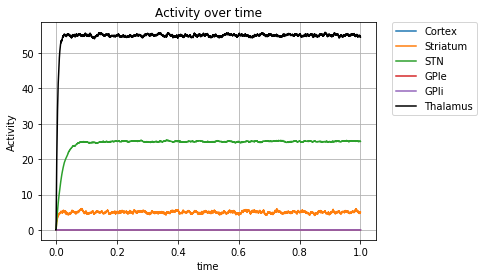

In [13]:
plt.plot(time_value,CtxTha_value,label='Cortex')
plt.plot(time_value,StrCtx_value,label='Striatum')
plt.plot(time_value,StnCtx_value,label='STN')
plt.plot(time_value,GpiStn_value,label='GPIe')
plt.plot(time_value,GpiStr_value,label='GPIi')
plt.plot(time_value,ThaGpi_value,'k',label='Thalamus')

plt.title('Activity over time')
plt.ylabel('Activity')
plt.xlabel('time')
plt.grid()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()